In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib
from IPython.display import display


# Load the datasets
test_features = pd.read_csv('../data/processed_data/testing_data.csv')
test_pred = pd.read_csv('../data/results/test_predictions.csv')    
fps_features = pd.read_csv('../data/FINAL_FPS.csv')

test_features_with_team = test_features.merge(
    fps_features[['gameId', 'playId', 'possessionTeam']],
    on=['gameId', 'playId'],
    how='left',
)

df = pd.concat(
    [test_features_with_team, test_pred[['predicted_class', 'true_label', 'predicted_proba']]], 
    axis=1  # Combine along columns
)

display(df.head())

,gameId,playId,week,quarter,gameClockSeconds,gameQuarterWeight,down,yardsToGo,yardsGained,expectedPoints,...,receiverAlignment,players_in_box_count,mismatchFound,motion_type,motion_player_count,pre_snap_time_duration,possessionTeam,predicted_class,true_label,predicted_proba
0,2022110607,3596,9,4,207,2.0,2,3,-1,4.714154,...,4,8,2.0,5,4,12.2,MIN,1,1,0.908016
1,2022110601,104,9,1,824,1.0,1,10,1,2.674001,...,7,7,0.0,0,0,15.8,CHI,0,1,0.188856
2,2022110601,802,9,1,18,1.0,3,10,10,3.294476,...,7,8,2.0,5,2,10.7,CHI,1,1,0.963534
3,2022110609,3743,9,4,269,2.0,3,4,9,2.049771,...,5,6,2.0,0,0,1.9,TB,1,1,0.974639
4,2022110602,1401,9,2,407,1.2,2,6,0,1.157813,...,4,7,1.0,0,0,6.2,CAR,1,1,0.692904


C:\Users\fishm\AppData\Local\Temp\ipykernel_9920\3663755346.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_predictions, x='possessionTeam', y='predicted_proba', palette='coolwarm')


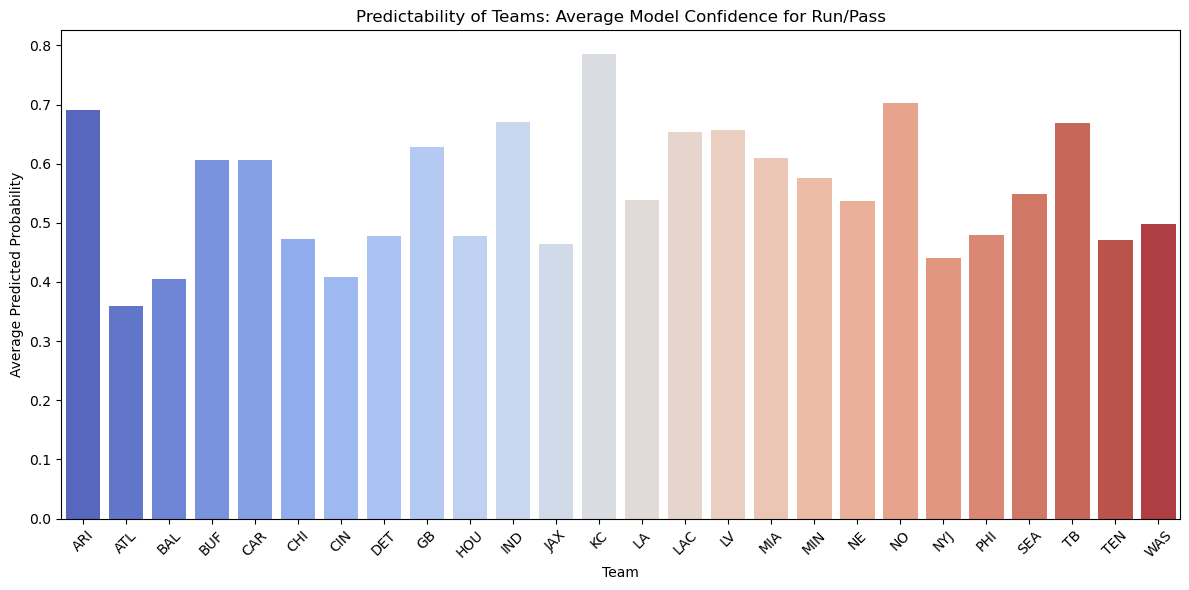

In [17]:
team_predictions = df.groupby('possessionTeam').agg({
    'predicted_proba': 'mean', 
    'true_label': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=team_predictions, x='possessionTeam', y='predicted_proba', palette='coolwarm')
plt.title('Predictability of Teams: Average Model Confidence for Run/Pass')
plt.xlabel('Team')
plt.ylabel('Average Predicted Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


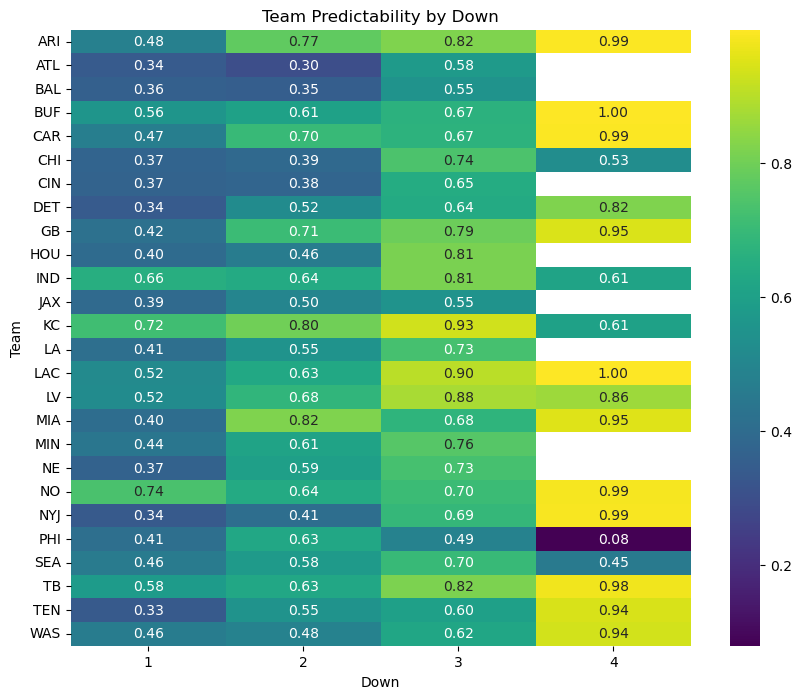

predicted_proba                               true_label  \
down                         1         2         3         4          1   
possessionTeam                                                            
ARI                   0.477554  0.774690  0.819678  0.993325   0.470588   
ATL                   0.338788  0.297821  0.577055       NaN   0.269231   
BAL                   0.358268  0.350370  0.552198       NaN   0.307692   
BUF                   0.560461  0.607157  0.665804  0.998960   0.619048   
CAR                   0.469435  0.700009  0.668547  0.992702   0.473684   

                                         
down                   2         3    4  
possessionTeam                           
ARI             0.684211  0.727273  0.5  
ATL             0.434783  0.666667  NaN  
BAL             0.263158  0.533333  NaN  
BUF             0.611111  0.555556  1.0  
CAR             0.666667  0.750000  1.0

In [23]:
team_situational = df.groupby(['possessionTeam', 'down']).agg({
    'predicted_proba': 'mean',
    'true_label': 'mean'
}).unstack('down')

plt.figure(figsize=(10, 8))
sns.heatmap(team_situational['predicted_proba'], annot=True, fmt=".2f", cmap='viridis')
plt.title('Team Predictability by Down')
plt.xlabel('Down')
plt.ylabel('Team')
plt.savefig('../visuals/Model Results/team_predictability_by_down.png', bbox_inches='tight')
plt.show()

display(team_situational.head())

C:\Users\fishm\AppData\Local\Temp\ipykernel_9920\1209523769.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


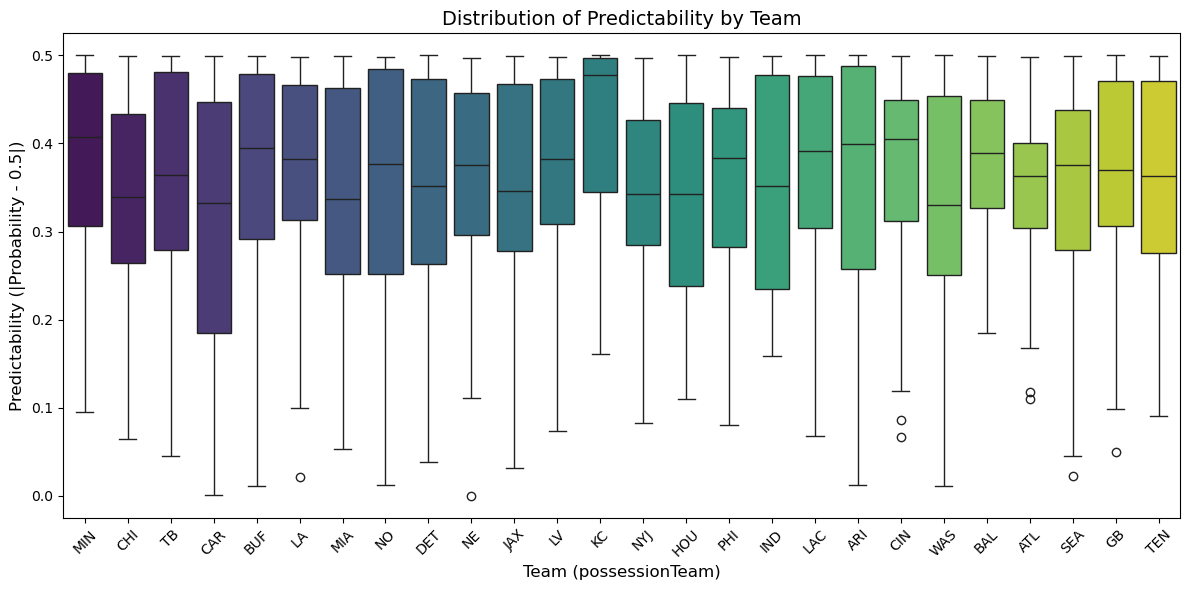

In [21]:
df['predictability'] = abs(df['predicted_proba'] - 0.5)
predictability_by_team = df.groupby('possessionTeam')['predictability'].mean()

import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot for predictability by team
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df, 
    x='possessionTeam', 
    y='predictability', 
    palette='viridis'
)

# Add labels and title
plt.title('Distribution of Predictability by Team', fontsize=14)
plt.xlabel('Team (possessionTeam)', fontsize=12)
plt.ylabel('Predictability (|Probability - 0.5|)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


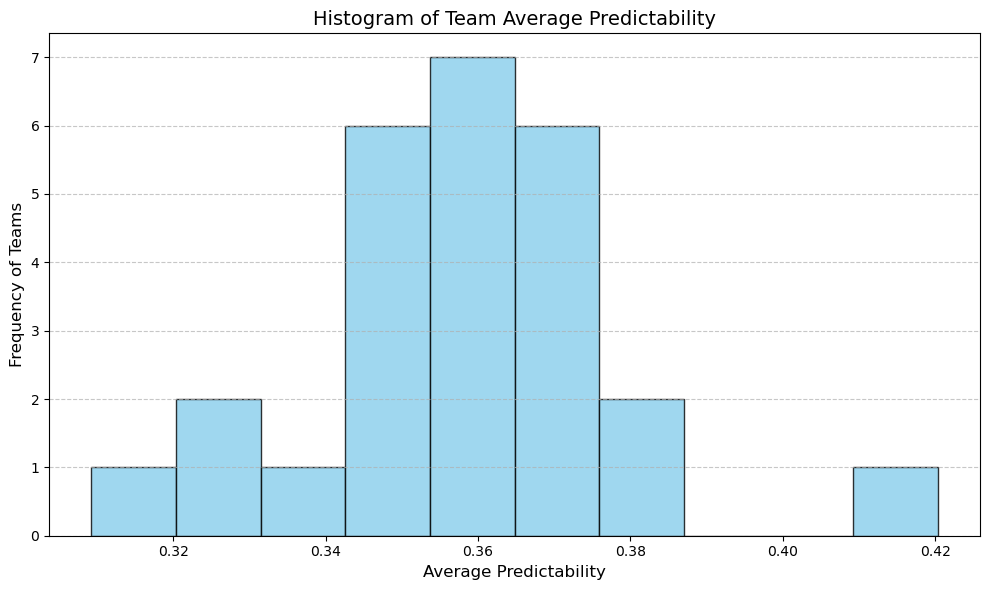

In [22]:
# Plot histogram of average predictability by team
plt.figure(figsize=(10, 6))
plt.hist(
    predictability_by_team, 
    bins=10, 
    color='skyblue', 
    edgecolor='black', 
    alpha=0.8
)

# Add labels and title
plt.title('Histogram of Team Average Predictability', fontsize=14)
plt.xlabel('Average Predictability', fontsize=12)
plt.ylabel('Frequency of Teams', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
